# CDF Matching Function

The Cumulative Distribution Function (CDF) Matching is a method used to remove systematic differences or rescale the signal from two different sensors or datesets (e.g. matching satellite observations with in situ observations or simulation data). The CDF is an observation operator converting from one sensor to another. The simples operator consists of a polynomial that matches the cumulative distribution of both sensors, somewhat resembling a continuous lookup table between the readings of the two sensors.

THe CS655 is a soil water reflectometer that relies on the lectromagnetic principle to estimate the relative permittivity of the soil, which is then converted into volumetric water content. The CS229 is a heat dissipation sensor encapsulated into porous ceramic. After a heat pulse, the rate of cooling is proportional to the energy-state of the water inside the porous matrix. This sensor estimates the matric potential of the ceramic cup at (presumably) equilibrium with the surrounding soil, a value that is then translated in to volumetric water content.

The estimation of the same variable (volumetric water content) from the different sensors can have strong biases due to the nature and limitation of each sensing technology. The CDF-matching method becomes handy to remove systematic biases between sensors and match their signal. In this exercise we will correct the signal from the CS229 to match that of the CS655.

$$ \theta_{655} \approx  \theta_{229adj} = \theta_{229} + f(\theta_{229})$$


In [92]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [93]:
# Load sensor data
df = pd.read_csv("../datasets/moisst_cs229_cs655.csv")
df.head()


,date,cs655,cs229
0,4/20/2012,0.297,0.324
1,4/21/2012,0.288,0.310
2,4/22/2012,0.268,0.290
3,4/23/2012,0.247,0.264
4,4/24/2012,0.225,0.235


In [94]:
# CHeck if there are NaN values in timeseries
df.isna().sum()


date      0
cs655     0
cs229    32
dtype: int64

In [95]:
# Replace missing values using a forward fill.
df["cs229"] = df["cs229"].fillna(method='ffill')


In [96]:
# Convert dates to Pandas datetime format
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y")


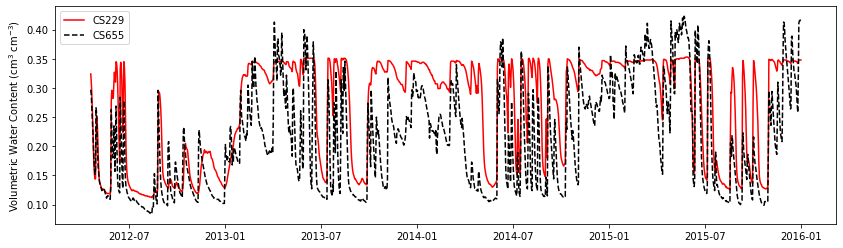

MBE: -0.057 cm^3/cm^3


In [172]:
# Plot data
plt.figure(figsize=(14,4))
plt.plot(df["date"], df["cs229"], "-r", label="CS229")
plt.plot(df["date"], df["cs655"], "--k", label="CS655")
plt.ylabel("Volumetric Water Content (cm$^3$ cm$^{-3}$)")
plt.legend()
plt.show()

MBE = np.nanmean(df["cs655"] - df["cs229"])
print("MBE:",round(MBE,3),"cm^3/cm^3")

In [146]:
# Compute difference between sensors
RMSD = np.sqrt(np.nanmean( (df["cs229"] - df["cs655"])**2))
print("RMSD:", round(RMSD,3), "cm^/cm^3")


RMSD: 0.082 cm^/cm^3


In [122]:
# Vector with number of observations
obs = np.arange(1,df.shape[0]+1)

# Sort observations
sorted_cs229 = np.sort(df["cs229"])
sorted_cs655 = np.sort(df["cs655"])


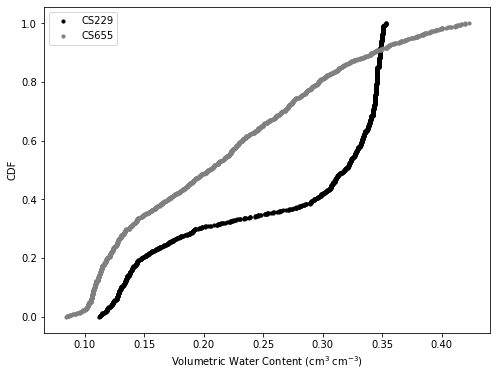

In [123]:
plt.figure(figsize=(8,6))
plt.scatter(sorted_cs229,obs/obs[-1], facecolor='k', s=10, label="CS229")
plt.scatter(sorted_cs655,obs/obs[-1], facecolor='grey', s=10, label="CS655")
plt.xlabel("Volumetric Water Content (cm$^3$ cm$^{-3}$) ")
plt.ylabel("CDF")
plt.legend()
plt.show()


In [150]:
# Compute delta
delta = sorted_cs655 - sorted_cs229 


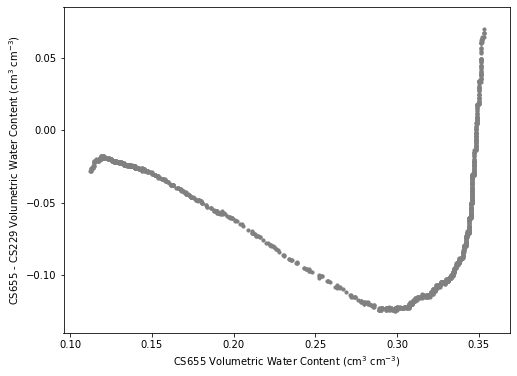

In [151]:
# Plot sorted data
plt.figure(figsize=(8,6))
plt.scatter(sorted_cs229, delta, marker='o', facecolor='grey', s=10)
plt.xlabel("CS655 Volumetric Water Content (cm$^3$ cm$^{-3}$)")
plt.ylabel("CS655 - CS229 Volumetric Water Content (cm$^3$ cm$^{-3}$)")
plt.show()


In [152]:
# Fit CDF Matching using Numpy
# Method may not converge if dataset contains missing values
par = np.polyfit(sorted_cs229, delta, 5)
print(par)

# Create function including optimized parameters
polyfun = np.poly1d(par)

# Predict CS655 from observations of the CS229 sensor
delta_pred = polyfun(sorted_cs229);


[ 1.23459478e+04 -1.36117894e+04  5.84133177e+03 -1.21699740e+03
  1.22326146e+02 -4.75698166e+00]


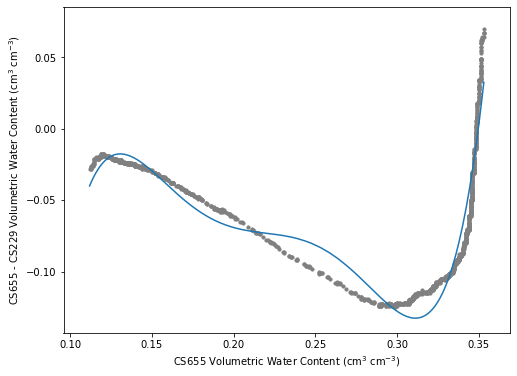

In [153]:
# Plot sorted data
plt.figure(figsize=(8,6))
plt.scatter(sorted_cs229, delta, marker='o', facecolor='grey', s=10)
plt.plot(sorted_cs229, delta_pred)

plt.xlabel("CS655 Volumetric Water Content (cm$^3$ cm$^{-3}$)")
plt.ylabel("CS655 - CS229 Volumetric Water Content (cm$^3$ cm$^{-3}$)")
plt.show()


In [165]:
# Adjusted soil moisture for the CS229
df["cs229_adj"] = df["cs229"] + polyfun(df["cs229"])


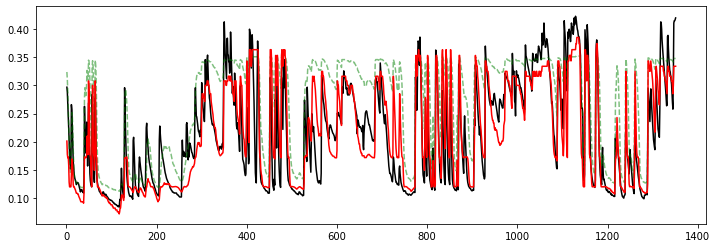

MBE: 0.0  cm^3/cm^3


In [175]:
plt.figure(figsize=(12,4))
plt.plot(obs, df["cs655"], '-k', label="CS655")
plt.plot(obs, df["cs229"], '--g', alpha=0.5, label="CS229")
plt.plot(obs, df["cs229_adj"], '-r', label="CS229_adj")
plt.show()

# Compute Mean Bias Error
MBE = np.nanmean(df["cs655"] - df["cs229_adj"])
print("MBE:",round(MBE,3)," cm^3/cm^3")

## References

Brocca, L., Hasenauer, S., Lacava, T., Melone, F., Moramarco, T., Wagner, W., Dorigo, W., Matgen, P., Martínez-Fernández, J., Llorens, P. and Latron, J., 2011. Soil moisture estimation through ASCAT and AMSR-E sensors: An intercomparison and validation study across Europe. Remote Sensing of Environment, 115(12), pp.3390-3408.

Drusch, M., Wood, E.F. and Gao, H., 2005. Observation operators for the direct assimilation of TRMM microwave imager retrieved soil moisture. Geophysical Research Letters, 32(15).

Reichle, R.H. and Koster, R.D., 2004. Bias reduction in short records of satellite soil moisture. Geophysical Research Letters, 31(19).